**Authors :** MADES Dimitri, MOYSE Laurine, JABRI Farah, SUKERATHA Alexandre
# MODS 203 Amazon Web Scrapping - Data Analysis

## Introduction

This notebook follows on from an initial web scraping exercise on the [Amazon](https://www.amazon.fr) website. From this first step, we extracted a large dataset of technical and economic characteristics of various household appliances (kettles, coffee grinders and coffee machines). 

The data collected will be the subject of an in-depth analysis of the logic underlying the algorithm for presenting products on Amazon pages. 
For this, we will borrow techniques from the field of econometrics, including OLS regressions and significance tests. 

**Problematic :**
> #### What are the features of a product that influence its position on an Amazon page? 


## Table of contents

* **[1. DataSet Overview](#chapter1)**
    * [1.1 Quick cleaning](#section_1_1)
    * [1.2 Features description](#section_1_2)
    * [1.3 Statistical report](#section_1_3)
        * [1.3.1 Quick descriptive stats](#sub_section_1_3_1)
        * [1.3.2 Identifying correlation between features](#sub_section_1_3_2)
    * [1.4 Data visualization - highlighting consumption and marketing principles](#section_1_4)
        * [1.4.1 The importance of COO (Country Of Origin)](#sub_section_1_4_1)
        * [1.4.2 About Rating and timesRated](#sub_section_1_4_2)
        * [1.4.4 More details regarding the price](#sub_section_1_4_4)
* **[2. Baseline - OLS approach](#chapter2)**
    * [2.1 Testing basic features](#section_2_1)
    * [2.2 Testing all features - FVS](#section_2_1)
* **[3. Case-by-case study of characteristics - development of new hypotheses](#chapter3)**
    * [3.1 Influence of the ranking in the visibility of a product](#section_3_1)
    * [3.2 Between practicality and aesthetics - materials used](#section_3_2)
    * [3.2 Impact of colors on sales](#section_3_3)
* **[4. Change of perspective - ML approachh](#chapter4)**
* **[Conclusion](#chapter5)**

## Importing libraries

In [328]:
from mpl_toolkits.mplot3d import axes3d
import plotly.graph_objects as go
from sklearn import preprocessing
import country_converter as coco
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
from scipy.stats import t
from scipy.stats import f
from matplotlib import cm
import seaborn as sns
import pandas as pd
import math as math
import numpy as np
import math as mt
import ast


In [329]:
import warnings
warnings.filterwarnings("ignore")


***

## 1. DataSet Overview <a class="anchor" id="chapter1"></a>

### 1.1 Quick cleaning <a class="anchor" id="section_1_1"></a>

First we import our raw DataSet and display the first two rows.

In [330]:
df = pd.read_csv('AmazonProjectDataF1.csv')
df.head(2)


,Unnamed: 0.1,ASIN,Best Sellers Rank,Brand,Capacity,Capacity (in liters),Color,Country of Origin,Customer Reviews,Date First Available,...,page,position,price,rating,ratings,stainless,three_stars,timesRated,title,two_stars
0,0,B07SYTRPSG,"{'Kitchen & Dining': 6084, 'Electric Coffee Bl...",Amazon Basics,30 Grams,0.030000,stainless steel,China,"4.5 out of 5 stars\n 9,362 ratings\n4.5 out...",2019-11-15,...,1,1,24.99,4.1,"72,15,6,2,4",1,6,9352,Amazon Basics Stainless Steel Electric Coffee ...,2
1,1,B07P7XF53S,"{'Kitchen & Dining': 107, 'Electric Spice Grin...",Kaffè,3.5 Ounces,0.103507,black,China,"4.4 out of 5 stars\n 16,325 ratings\n4.4 ou...",2019-11-16,...,1,2,24.95,4.9,"70,16,6,3,5",1,6,16304,Kaffe Coffee Grinder Electric - Spice Grinder ...,3


To simplify access and understanding of certain features, we rename some columns.

In [331]:
df.rename(
    columns={
        "Unnamed: 0": "id",
        "Color": "color",
        "Voltage": "voltage",
        "Wattage": "wattage",
        "Brand": "brand",
        "Style": "style",
        "Best Sellers Rank": "best",
        "Capacity (in liters)": "capacity",
        "Item Weight (in kg)": "weight",
        "Filter Type": "reusable",
        "Recommended Uses For Product": "recommendation",
        "Special Feature": "special",
        "Specific Uses For Product": "specific",
        "is_programmable": "programmable",
        "Date First Available": "first",
    },
    inplace=True,
)

df.columns.unique()


Index(['Unnamed: 0.1', 'ASIN', 'best', 'brand', 'Capacity', 'capacity',
       'color', 'Country of Origin', 'Customer Reviews', 'first', 'reusable',
       'HII_buttons', 'HII_dial', 'HII_touch_pad', 'HII_touchscreen',
       'Item Weight', 'weight', 'Item model number', 'Manufacturer',
       'Material', 'Model Name', 'Package Dimensions', 'Product Dimensions',
       'recommendation', 'special', 'specific', 'style', 'id', 'voltage',
       'wattage', 'contains_ceramic', 'contains_glass', 'contains_metal',
       'contains_plastic', 'contains_rubber', 'features_nb', 'five_stars',
       'four_stars', 'programmable', 'link', 'one_star', 'page', 'position',
       'price', 'rating', 'ratings', 'stainless', 'three_stars', 'timesRated',
       'title', 'two_stars'],
      dtype='object')

`Package Dimensions` and `Product Dimensions` provide the same information, so we merge them into one feature.

In [332]:
list = []
for i in df.index:
    if type(df["Package Dimensions"][i]) != float:
        list.append(df["Package Dimensions"][i])
    else:
        list.append(df["Product Dimensions"][i])
# We merge the two features into a new "dimensions" feature
df["dimensions"] = list


Scraping allowed us to recover for each product the `page` where it is presented as well as its `position` within this page. We combine these two pieces of information into a single feature `order` based on the `page` and position `features`. 

Each page contains 60 items, so the following calculation can be made:

In [333]:
df['order']=df['id']+1

We adapt the format of the `Customer Reviews` feature. This allows us to check the validity of the `rating` and `timesrated` data.

In [334]:
def retrieve(position):
    res = []
    for i in df.index:
        if type(df["Customer Reviews"][i]) != float:
            liste = df["Customer Reviews"][i].split(" ")
            res.append(float(liste[position].replace(",", "")))
        else:
            res.append(df["Customer Reviews"][i])
    return res


df["rating"] = retrieve(0)
df["timesRated"] = retrieve(8)


We then have to deal with the `price` and `reusable` columns. These have format errors.

In [335]:
# Some entries in the `reusable` category have the value "reusable" instead of 1.
for i in df.reusable[df.reusable == "Reusable"].index:
    df.reusable[i] = 1

# Converting eventual strings into float
df.price = pd.to_numeric(df.price)
df.reusable = pd.to_numeric(df.reusable)


Finally, we delete the columns that will not be used and rearrange them for clarity.

In [336]:
df.drop(
    columns=[
        "Capacity",
        "Item Weight",
        "Item model number",
        "Material",
        "Model Name",
        "Unnamed: 0.1",
        "Package Dimensions",
        "Product Dimensions",
        "Customer Reviews",
        "ratings",
        "Manufacturer",
    ],
    inplace=True,
)


Rearranging the columns,

In [337]:
df = df[
    [
        "id",
        "best",
        "price",
        "rating",
        "timesRated",
        "features_nb",
        "one_star",
        "two_stars",
        "three_stars",
        "four_stars",
        "five_stars",
        "stainless",
        "contains_ceramic",
        "contains_glass",
        "contains_metal",
        "contains_plastic",
        "contains_rubber",
        "programmable",
        "reusable",
        "HII_buttons",
        "HII_dial",
        "HII_touch_pad",
        "HII_touchscreen",
        "title",
        "ASIN",
        "link",
        "first",
        "recommendation",
        "special",
        "specific",
        "style",
        "color",
        "brand",
        "page",
        "position",
        "order",
        "Country of Origin",
        "capacity",
        "voltage",
        "wattage",
        "weight",
        "dimensions",
    ]
]


### 1.2 Features description <a class="anchor" id="section_1_2"></a>

In [338]:
# We display the first two lines of our ready-to-use DataSet.
df.head(2)


,id,best,price,rating,timesRated,features_nb,one_star,two_stars,three_stars,four_stars,...,brand,page,position,order,Country of Origin,capacity,voltage,wattage,weight,dimensions
0,0,"{'Kitchen & Dining': 6084, 'Electric Coffee Bl...",24.99,4.5,9362.0,33,4,2,6,15,...,Amazon Basics,1,1,1,China,0.030000,NaN,NaN,3.395115,3.5 x 3.72 x 6.9
1,1,"{'Kitchen & Dining': 107, 'Electric Spice Grin...",24.95,4.4,16325.0,33,5,3,6,16,...,Kaffè,1,2,2,China,0.103507,NaN,NaN,3.306930,4 x 4 x 6.7


#### **Table of features**
|Name |Type |Description|
|--|--|--|
|id|int|Index of the object in the dataframe from which it originates.|
|best|string|Best seller rank of the product in a few categories.| 
|price|float|Price of the product in $.|
|rating|float|Customer's rating out of 5.|
|timesRated|float|Number of times the object was rated.|
|features_nb|int|Number of categories in which information is provided on the product page.|
|one_star|int|Percentage of one-star ratings assigned to the product.|
|two_stars|int|Percentage of two-stars ratings assigned to the product.|
|three_stars|int|Percentage of three-stars ratings assigned to the product.|
|four_stars|int|Percentage of four-stars ratings assigned to the product.|
|five_stars|int|Percentage of five-stars ratings assigned to the product.|
|stainless|int|Indicates if the product contains stainless steel.|
|contains_ceramic|int|Indicates if the product contains ceramic.|
|contains_glass|int|Indicates if the product contains glass.|
|contains_metal|int|Indicates if the product contains metal.|
|contains_plastic|int|Indicates if the product contains plastic.|
|contains_rubber|int|Indicates if the product contains rubber|
|programmable|float|Indicates if the product is programmable.|
|reusable|float|Indicates whether the coffee capsules are reusable.|
|HII_buttons|int|Indicates if the product has this feature.|
|HII_dial|int|Indicates if the product has this feature.|
|HII_touchpad|int|Indicates if the product has this feature.|
|HII_touchscreen|int|Indicates if the product has this feature.|
|title|string|Title of the product.|
|ASIN|string|Amazon Standard Identification Number.|
|link|string|Link to the product page.|
|recommendation|string|Advice for the customer when using the product.|
|special|string|Description of potential special features.|
|specific|string|Specific uses for the product.|
|style|string|Description of the style of the product.|
|color|string|Color of the product.|
|brand|string|Brand of the product.|
|page|int|Mumber of the page on which the product appears.|
|position|int|Article position in its page regarding its visibility.|
|Country of Origin|int|Refers to the country of origin of the product.|
|capacity|float|Holding capacity for the product in liters.|
|voltage|float|Required voltage for the product.|
|wattage|float|Wattage of the product.|
|weight|float|Weight capacity for the product in kilograms.|
|dimensions|string|Dimensions of the product in inches.|

We then provide an overview of the missing data. The following code is based on some recommendations from [StackOverflow](https://stackoverflow.com/questions/26266362/how-do-i-count-the-nan-values-in-a-column-in-pandas-dataframe).

In [339]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )
    return mis_val_table_ren_columns


missing_values_table(df)


Your selected dataframe has 42 columns.
There are 20 columns that have missing values.


,Missing Values,% of Total Values
recommendation,4232,74.0
voltage,4171,72.9
special,4050,70.8
style,3901,68.2
specific,3811,66.6
HII_touch_pad,3357,58.7
HII_touchscreen,3357,58.7
HII_dial,3357,58.7
programmable,3357,58.7
reusable,3327,58.2


### 1.3 Statistical report <a class="anchor" id="section_1_3"></a>

#### 1.3.1 Quick descriptive stats <a class="anchor" id="sub_section_1_3_1"></a>

We then provide a commented statistical report on the numerical characteristics of our DataFrame. We will first give an overall report and then focus on each item category.

#### **a. Statistical report - all items considered**

In [340]:
stat_report_global = df.describe()
stat_report_global[['price', 'rating', 'timesRated', 'features_nb']]

,price,rating,timesRated,features_nb
count,5721.000000,5188.000000,5188.000000,5721.000000
mean,68.678762,4.292618,1800.510409,33.478413
std,91.256419,0.425137,4878.611437,6.216344
min,2.990000,1.000000,1.000000,19.000000
25%,24.990000,4.100000,25.000000,29.000000
50%,39.990000,4.300000,132.000000,33.000000
75%,79.990000,4.600000,1162.000000,38.000000
max,1757.980000,5.000000,90495.000000,49.000000


#### **b. Statistical report - coffee grinders only**

In [341]:
stat_report_cf_grinder = df.iloc[range(0, 1872)].describe()
stat_report_cf_grinder[['price', 'rating', 'timesRated', 'features_nb']]

,price,rating,timesRated,features_nb
count,1872.000000,1697.000000,1697.000000,1872.000000
mean,60.934904,4.296995,2270.723041,28.658120
std,58.425931,0.348747,5447.407225,3.850576
min,6.390000,1.000000,1.000000,19.000000
25%,19.990000,4.100000,21.000000,25.000000
50%,33.950000,4.300000,132.000000,30.000000
75%,95.990000,4.500000,1162.000000,31.000000
max,699.000000,5.000000,58269.000000,39.000000


#### **a. Statistical report - kettles only**

In [342]:
stat_report_kettle = df.iloc[range(1872, 3357)].describe()
stat_report_kettle[['price', 'rating', 'timesRated', 'features_nb']]

,price,rating,timesRated,features_nb
count,1485.000000,1405.000000,1405.000000,1485.000000
mean,45.504970,4.408256,1551.223488,35.930640
std,32.347952,0.342964,3974.898599,4.237067
min,6.990000,1.000000,1.000000,24.000000
25%,27.000000,4.300000,43.000000,34.000000
50%,35.990000,4.400000,233.000000,37.000000
75%,49.990000,4.600000,1131.000000,39.000000
max,399.000000,5.000000,53354.000000,46.000000


#### **c. Statistical report - coffee machines only**

In [343]:
stat_report_cf_machine = df.iloc[range(3357, 5721)].describe()
stat_report_cf_machine[['price', 'rating', 'timesRated', 'features_nb']]

,price,rating,timesRated,features_nb
count,2364.000000,2086.000000,2086.000000,2364.000000
mean,89.368096,4.211170,1585.887824,35.755076
std,126.433084,0.505808,4915.884041,6.569244
min,2.990000,1.600000,1.000000,26.000000
25%,23.945000,4.000000,24.000000,29.000000
50%,49.990000,4.300000,112.000000,37.000000
75%,104.587500,4.500000,865.750000,41.000000
max,1757.980000,5.000000,90495.000000,49.000000


#### 1.3.2 Identifying correlation between features <a class="anchor" id="sub_section_1_3_2"></a>

In this section we will draw correlation heat maps to visualise the strength of the relationships between our numerical features. We therefore need to reduce our original data set to the following features :

**Correlation features considered :**

|Name |Type |Description|
|--|--|--|
|order|int|position of the article on the search page of the generic product|
|price|float|Price of the product in $.|
|rating|float|Customer's rating out of 5.|
|timesRated|float|Number of times the object was rated.|
|features_nb|int|Number of categories in which information is provided on the product page.|
|one_star|int|Percentage of one-star ratings assigned to the product.|
|two_stars|int|Percentage of two-stars ratings assigned to the product.|
|three_stars|int|Percentage of three-stars ratings assigned to the product.|
|four_stars|int|Percentage of four-stars ratings assigned to the product.|
|five_stars|int|Percentage of five-stars ratings assigned to the product.|


In [344]:
df_heatmap = df[['order', 'price', 'rating', 'timesRated', 'features_nb', 'one_star', 'two_stars', 'three_stars', 'four_stars', 'five_stars']]

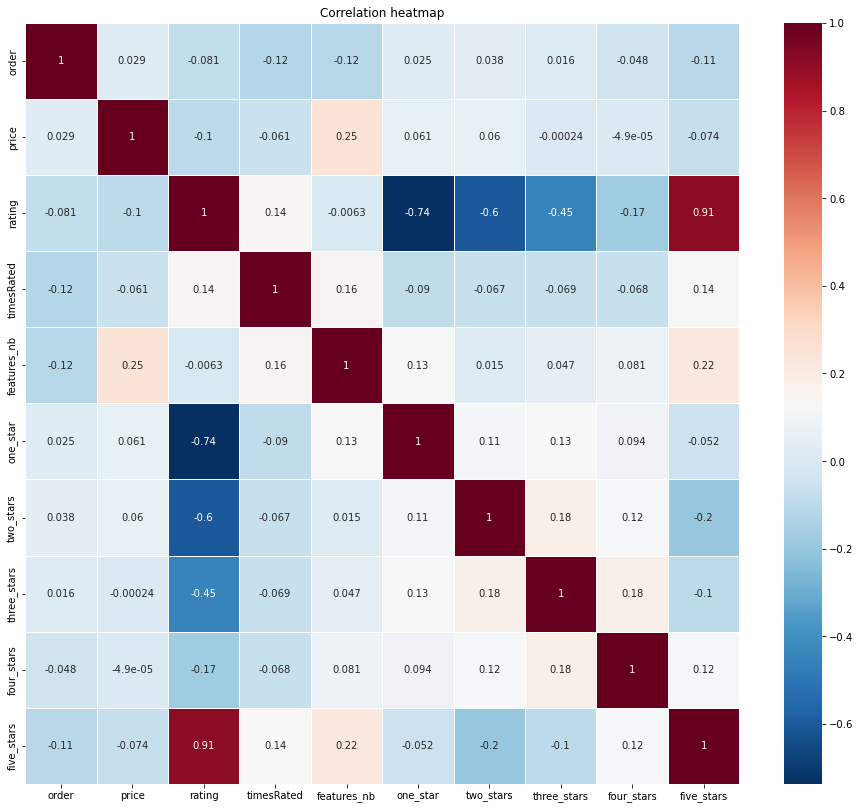

In [345]:
# Adjusting the size of the figure
plt.figure(figsize=(16,14))

# Correlation heatmap
htmp = sns.heatmap(df_heatmap.corr(), annot=True, linewidths=.5,  cmap="RdBu_r")
htmp.set_title("Correlation heatmap")
plt.show()
plt.close()

**Comments on the heatmap:** We can make multiple observations on this graph,
* As expected, the one and two star percentage ratings are <span style="color:blue">**negatively correlated**</span> with the ranking. Surprisingly, three and four star ratings are also <span style="color:blue">**negatively correlated**</span>. Only the percentage of five-star ratings is <span style="color:red">**positively correlated**</span> (coefficient almost equal to 1). In general, an _n_ star review is slightly <span style="color:red">**positively correlated**</span> with its _n-1_ and _n+1_ neighbouring star reviews.
* One thing worth mentioning is that price is <span style="color:red">**positively correlated**</span> with the number of features. Higher priced items are more likely to have a full description. This can be interpreted by the fact that luxury products tend to rely more on marketing and informing consumers of all the competitive advantages of the product.
* Finally, the order characteristic (feature of interest) does not show a clear correlation with the other characteristics. This complicates our future analysis.

### 1.4 Data Visualization - highlighting consumption and marketing principles <a class="anchor" id="section_1_4"></a>

#### 1.4.1 The importance of COO (Country Of Origin) <a class="anchor" id="sub_section_1_4_1"></a>

A first step in visualising our dataset is to identify the country of origin of our products. This feature can be relevant when dealing with popularity criteria. Indeed, the COO can often influence the consumer's decision by acting as a guarantee of good product quality. 

<i>Balabanis and Diamantopoulous, 2004 [Domestic country bias, country-of-origin effects and consumer ethnocentrism: a multidimensional unfolding approach](https://journals.sagepub.com/doi/abs/10.1177/0092070303257644)</i>.

In [346]:
# We use the iso3 encoding to identify the countries in our DataSet
df['iso_3'] = coco.convert(names=df['Country of Origin'], to='ISO3', not_found=None)

# Counting the number of products for each country
df_COO_count = df['iso_3'].value_counts().to_frame().reset_index()
df_COO_count.columns = ['iso_3', 'nb_products']

# Adding full names for DataViz
df_COO_count['Country'] = coco.convert(names=df_COO_count['iso_3'], to='name_short', not_found=None)
df_COO_count = df_COO_count[df_COO_count['Country']!='nan']

# Computing the average price of a product for each country
df_COO_price = df.groupby('iso_3', as_index=False)['price'].mean()

# Converting floats to strings for map displays
df_COO_count['nb_products_str'] = df_COO_count['nb_products'].astype(str)
df_COO_price['price'] = df_COO_price['price'].apply(lambda price : round(price, 2)).astype(str)

# Merging the two sub-DataFrame
df_COO = df_COO_count.merge(df_COO_price, on='iso_3')

df_COO.head(3)


nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not fo

,iso_3,nb_products,Country,nb_products_str,price
0,CHN,2815,China,2815,57.94
1,USA,49,United States,49,55.36
2,IDN,48,Indonesia,48,48.87


We can now display a map showing the origins of the different products scrapped on Amazon.

In [347]:
figure_1 = go.Figure(
    data=go.Choropleth(
        locations=df_COO["iso_3"],
        z=df_COO["nb_products"],
        text=df_COO["Country"]
        + "<br>Nb. of products : "
        + df_COO["nb_products_str"]
        + "<br>Average product price : "
        + df_COO["price"],
        colorscale="emrld",  #'agsunset_r'
        autocolorscale=False,
        marker_line_color="darkgray",
        marker_line_width=0.5,
        colorbar_title="Number of <br>products",
    )
)

figure_1.update_layout(
    title_text="figure 1 : <b>COO of scrapped Amazon products : Kettles, Coffee grinders and Coffee machines</b> <br>(Hover for <i>Country</i> names, <i>nb_products</i>, and <i>average_price</i>) ",
    geo=dict(showcoastlines=False, projection_type="robinson"),
)

figure_1.update_layout(
    margin=dict(l=50, r=0, b=50, t=100),
    height=550,
    dragmode= False,
    annotations=[
        dict(
            text="<i>Data Source: Amazon</i>",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0,
        )
    ],
)

figure_1.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)

figure_1.show()


#### 1.4.2 About `Rating` and `timesRated` <a class="anchor" id="sub_section_1_4_2"></a>

First, we create a new feature indicating the type of each item.

|Name |Type |Description|
|--|--|--|
|object|string|type of article among : {kettle, coffee grinder, coffee machine}|



In [348]:
grd_ind = range(0, 1872)
ket_ind = range(1872, 3357)
cof_ind = range(3357, 5721)

df.loc[grd_ind, "object"] = "coffee grinder"
df.loc[ket_ind, "object"] = "kettle"
df.loc[cof_ind, "object"] = "coffee machine"

To better understand the data, we display a scatter plot between the `timesRated` and `rating` features.

In [349]:
figure_2 = px.scatter(
    data_frame=df.dropna(subset=["rating", "timesRated"]),
    y="timesRated",
    x="rating",
    color="object",
    labels={
        "object":"<b>product category</b>",
    },
    title="figure 2 : <b><i>timesRated</i> as a function of <i>rating</i></b><br><i>(Hover over the data points for additional information).</i>",
)

figure_2.show()

**Comments on Figure 2 :** One thing that stands out in this figure is that highly commented products (rated time > 20k) all have ratings above four stars. Multiple hypothesis can be made from such results :
* **Snowball effect :** a genuinely good product will get good reviews and new customers who will leave good reviews themselves.
* **Fake reviews :** Products with a large number of reviews are more likely to be subject to false reviews that would increase their score.
* **Social influence :** Large amounts of ratings can influence new reviews by dampening them.

<i>Sridhar, S., & Srinivasan, R. (2012). [Social Influence Effects in Online Product Ratings. Journal of Marketing, 76(5), 70–88.](https://doi.org/10.1509/jm.10.0377)</i>

#### 1.4.3 More details regarding the `price` <a class="anchor" id="sub_section_1_4_3"></a>

In this section we will try to give a decent visualisation of the distribution of prices between the different items we deal with.

In [350]:
x0 = df[df["object"] == "coffee grinder"]["price"]
x1 = df[df["object"] == "kettle"]["price"]
x2 = df[df["object"] == "coffee machine"]["price"]

df_price = pd.DataFrame(
    dict(
        series=np.concatenate(
            (
                ["Coffee grinder"] * len(x0),
                ["Kettle"] * len(x1),
                ["Coffee machine"] * len(x2),
            )
        ),
        data=np.concatenate((x0, x1, x2)),
    )
)

figure_3 = px.histogram(
    df_price,
    x="data",
    color="series",
    barmode="overlay",
    nbins=190,
    title="figure 3 : <b><i>price</i> overlay histograms for each type of product</b><br><i>(Prices above $400 USD are not displayed for better visualization).</i>",
    labels={
        "series": "<b>product category</b>",
        "data": "price ($USD)",
    },
)

figure_3.update_layout(
    bargap=0.01,
    xaxis={"range": [0, 400]},
)


**Comments on Figure 3 :** The vast majority of the products we handle are priced between $15 and $150 USD (regardless of the category). 

Let's see if we can find trends between the following three features: `price`, `rating`, `timesRated`. To do this, we will implement a 3D scatter plot of our data.

In [351]:
figure_4 = px.scatter_3d(
    df,
    y="rating",
    z="price",
    x="timesRated",
    color="price",
    opacity=0.7,
    title="figure 4 : <b>3d Scatter Plot between <i>price</i>, <i>rating</i> and <i>timesRated</i></b><i><br>(Hover for additional information - manipulable in 3d).</i>",
)


figure_4.update_layout(
    height=600,
    width=790,
    margin=dict(t=80, r=0, l=0, b=10),
)

camera = dict(eye=dict(x=2, y=2, z=0.1))

figure_4.update_layout(scene_camera=camera)

figure_4.show()


**Comments on Figure 4 :** It is interesting to note that a large group of data points are clustered in the lower right corner of the cube. These are low price, high rating, many rated items. We can easily see outliers that differ from our identified main group :
* high price, high rating, many rated items.
* low price, low rating, not many rated items.
* low price, high rating, many rated items.

In the end, all data points are collected on the edges of the cube.

***

## 2. Baseline - OLS approach <a class="anchor" id="chapter2"></a>

### 2.1 Testing basic features <a class="anchor" id="section_2_1"></a>

In developing our model for determining product positioning criteria on [Amazon](https://amazon.fr) : we develop an initial naive model whose performance will serve as a basis for further analysis. We use an OLS approach applied to the following variables.

The explicative variables are the first ones that come to mind when buying a product. Its price, its rating, the number of times it has been rated (gives credibility to the rating) and the amount of information given by the manufacturer (also a guarantee of good manufacturing).

**Dependant variable :**
|Name |Type |Description|
|--|--|--|
|lorder|int|logarithm of the position of the article on the search page of the generic product|

_Small visualization of the data of the `order` function :_

In [352]:
figure_4 = px.histogram(
    df,
    x="order",
    nbins=100,
    title="figure 4 : <b><i>order</i> histogram</b>",
    width=800,
    labels={},
)

figure_4.update_layout(
    bargap=0.01,
)

**Comments on the figure:** We identify three clear steps that result from the scrapping of 3 types of items (kettles, coffee grinders, coffee machines) that each have a different number of items in line.

To perform our analysis, we will consider the logarithm `lorder` of the previous `order` feature.

In [353]:
df['lorder'] = np.log(df.order)

figure_5 = px.histogram(
    df,
    x="lorder",
    nbins=100,
    title="figure 5 : <b><i>lorder</i> histogram (Dependant variable of the model)</b>",
    width=800,
    labels={},
)

figure_5.update_layout(
    bargap=0.01,
)

The logarithm of `order` appears to be distributed according to an increasing exponential. We will use it as a reference variable for the regression. We know take a look at the explicative variables we will use :

**Explicative variables :**
|Name |Type |Description|
|--|--|--|
|price|float|Price of the product in $|
|rating|float|Customer's rating out of 5|
|timesRated|float|Number of times the object was rated|
|features_nb|int|Number of categories in which product information is provided|


In [354]:
# Subset of the DataFrame we are working with
df_baseLine = df.dropna(subset=["rating", "timesRated"])

# Dependant variable
y = np.log(df_baseLine.order)

# Explicative variable
const = np.ones(np.shape(y))
X = np.column_stack(
    (
        const,
        df_baseLine.price,
        df_baseLine.rating,
        df_baseLine.timesRated,
        df_baseLine.features_nb,
    )
)

# OLS regression
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Residuals analysis
residuals = results.resid


                            OLS Regression Results                            
Dep. Variable:                  order   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     125.7
Date:                Sun, 22 Jan 2023   Prob (F-statistic):          1.44e-102
Time:                        02:06:41   Log-Likelihood:                -7266.6
No. Observations:                5188   AIC:                         1.454e+04
Df Residuals:                    5183   BIC:                         1.458e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1034      0.161     50.421      0.0

Let's take a closer look at the residuals of our naive model, 

In [355]:
figure_6 = px.histogram(
    data_frame=residuals,
    x=0,
    title="figure 6 : <b><i>results.resid</i> histogramm</b><br><i>(residuals of the OLS basline regression)</i>",
    width=700,
    labels={
        "0": "model residuals",
    },
)

figure_6.update_layout(
    bargap=0.05,
)

The distribution of the residuals is close to a centered normal distribution. The estimator is therefore unbiased. But the R-squared coefficient is equal to 0.088. This means that only 8.8% of the `order` values are correctly explained by the model.

Let's take a closer look at the signs of the obtained coefficients:
* The coefficient in front of `price` is positive. This means that the price increases with the order of an item. The cheapest and best ranked items in this category are displayed first. 

* The coefficient in front of `rating`, `timesRated` and `features_nb` is negative, which is also logical. The items displayed first have a higher rating, are rated more times and provide more information about the product.

### 2.2 Testing all features - FVS (Forward Variable Selection) <a class="anchor" id="section_2_2"></a>

Forward selection is a type of stepwise regression which begins with an empty model and adds in variables one by one. In each forward step, you add the one variable that gives the single best improvement to your model. <i>(Source : [statisticshowto](https://www.statisticshowto.com/forward-selection/#:~:text=Forward%20selection%20is%20a%20type,best%20improvement%20to%20your%20model.))</i>

In this case, we will choose the absolute value of the student t of the newly added variable as the improvement criterion.

In [356]:
# Subset of the DataFrame we are working with
df_fvs = df.dropna(subset=["rating", "timesRated"])

# Dependant variable
y = np.log(df_fvs.order)

# Explicative variable
const = np.ones(np.shape(y))
X_fvs = np.column_stack(
    (
        df_fvs.price,
        df_fvs.rating,
        df_fvs.timesRated,
        df_fvs.features_nb,
        df_fvs.one_star,
        df_fvs.two_stars,
        df_fvs.three_stars,
        df_fvs.four_stars,
        df_fvs.five_stars,   
    )
)

# Forward Variable Selection Algorithm
Features = np.arange(1, 10).tolist()
list = []
results = []
while (len(Features)!=0):
    t_max = -math.inf
    for feature in Features:
        x = X_fvs[:, list + [feature-1]]
        # OLS regression
        model_fwd = sm.OLS(y, sm.add_constant(x)).fit()
        # Retrieving t-test and p-value
        pvalue = model_fwd.pvalues[-1]
        t_val = model_fwd.tvalues[-1]
        # Searching for the max 
        if (abs(t_val) >= t_max):
            max_feature = [feature, pvalue]
            t_max = abs(t_val)
    # Adding the feature to our list of arrivals
    list.append(max_feature[0]-1)
    # Removing the feature from the list of remaining features
    Features.remove(max_feature[0])
    # Adding the p-value to our results list
    results.append(max_feature)
    
print('* Order of appearance of features :')
print(list)

* Order of appearance of features :
[2, 3, 1, 0, 7, 8, 4, 6, 5]


We can interpret the order of appearance of the features as their relative importance in building the model. Our results seem to be quite coherent, with the sub-features (percentage of opinions for each number of stars, 4 to 8 in the results list) being placed last. On the contrary, the primary features appear first (`price`, `rating`, `timesRated`).

We can conclude about the importance of the feature `timesRated` by trying to predict the feature `order` (placed first on the appearance list).

***

## 3. Case-by-case study of characteristics - development of new hypotheses <a class="anchor" id="chapter3"></a>

Our initial econometric approach failed to find useful clues to explain the visibility of a product based on its technical and economic characteristics. In this section, we will use a case-by-case approach to find models that could help us better understand the underlying algorithms used on the Amazon website.

### 3.1 Influence of the ranking in the visibility of a product <a class="anchor" id="section_3_1"></a>

As we saw in the previous OLS analysis, the ranking function appeared in third place in the order of importance in our model. In order to better understand why what seemed to be a crucial parameter was ranked so low, we will proceed to an additional visualisation of the data and try to formulate new hypotheses for a future model.

To do this, we create a heat map to visualise the average score as a function of the page and the position of an element.

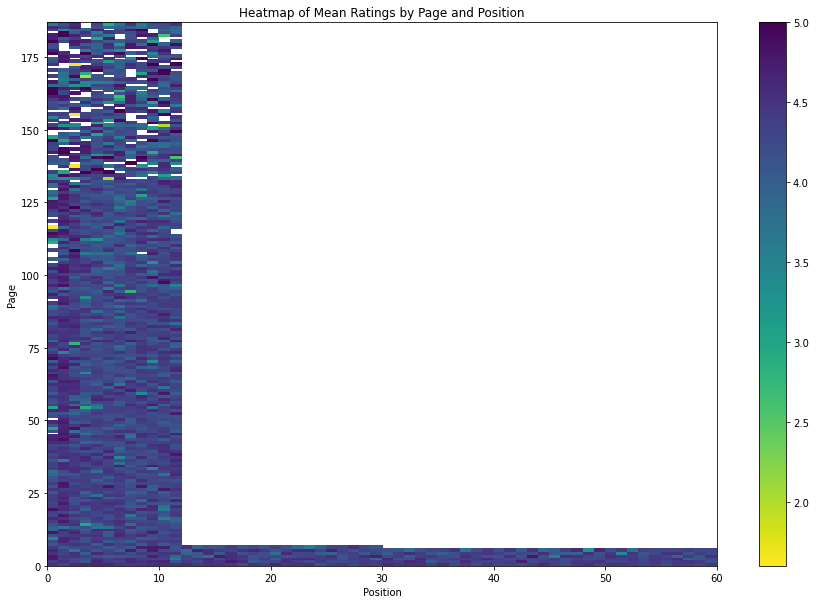

In [357]:
# Average ranking according to the page and the position
mean_ratings = df.groupby(['page', 'position'])['rating'].mean().reset_index()

# Overall figure
plt.figure(figsize=(15,10))

# Creation of a heat map 
plt.pcolor(mean_ratings.pivot("page", "position", "rating"), cmap='viridis_r')
plt.colorbar()

# Titles
plt.title("Heatmap of Mean Ratings by Page and Position")
plt.xlabel("Position")
plt.ylabel("Page")

plt.show()
plt.close()

**Comment on the figure :** This overview does not reveal any obvious pattern. We will then consider subsets of our original dataset. 
* First, the items contained on pages 1 to 15. 
* Second, the items contained on pages 30 to 60.

<i>Note that after page 6, the number of articles is reduced to 30 articles per page, and after page 7, it is reduced to 12 articles per page.</i>

#### **a. Items contained in pages 1 to 15**

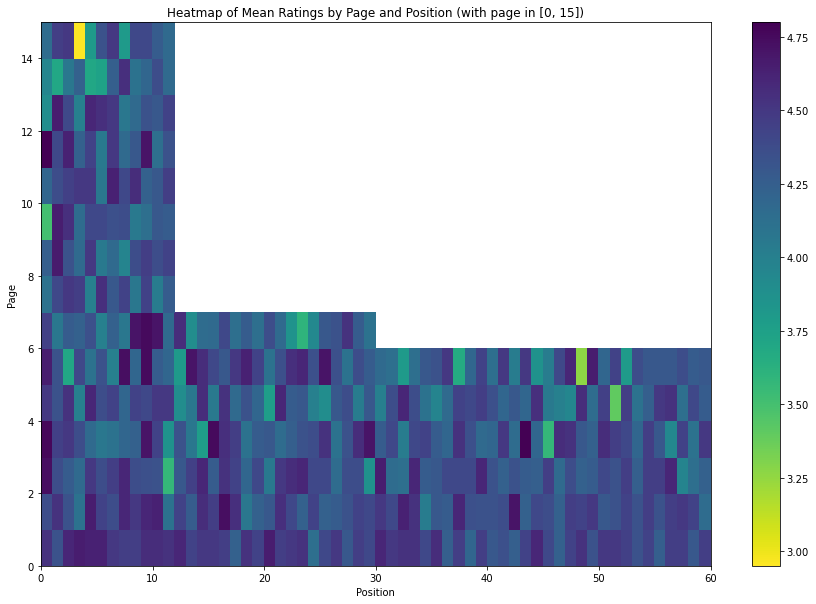

In [358]:
# Filtering the data
data = df.query('page >= 1 and page <= 15')

# Analysis of the average score according to the page and the position
mean_ratings = data.groupby(['page', 'position'])['rating'].mean().reset_index()

# Overall figure
plt.figure(figsize=(15,10))

# Creation of a heat map 
plt.pcolor(mean_ratings.pivot("page", "position", "rating"), cmap='viridis_r')
plt.colorbar()

# Titles
plt.title("Heatmap of Mean Ratings by Page and Position (with page in [0, 15])")
plt.xlabel("Position")
plt.ylabel("Page")

plt.show()
plt.close()

**Comments on the figure :** the first few pages displayed high-rated articles. Although there is no visible color gradient that would show a clear positive correlation between the rating and its visibility. In fact, we have to think in terms of sales. Highly rated products are not necessarily the best selling products. A highly rated product with a high price (luxury products) has a smaller audience than an average cheap item. 

Nevertheless, products with an average rating less than or equal to 3 do not appear until after the 14th page. One thing that might be interesting for future analysis would be to implement a new Boolean feature: `rating less than 3 stars` that would surely have a great correlation with the ordering function.

#### **b. Items contained in pages 30 to 60**

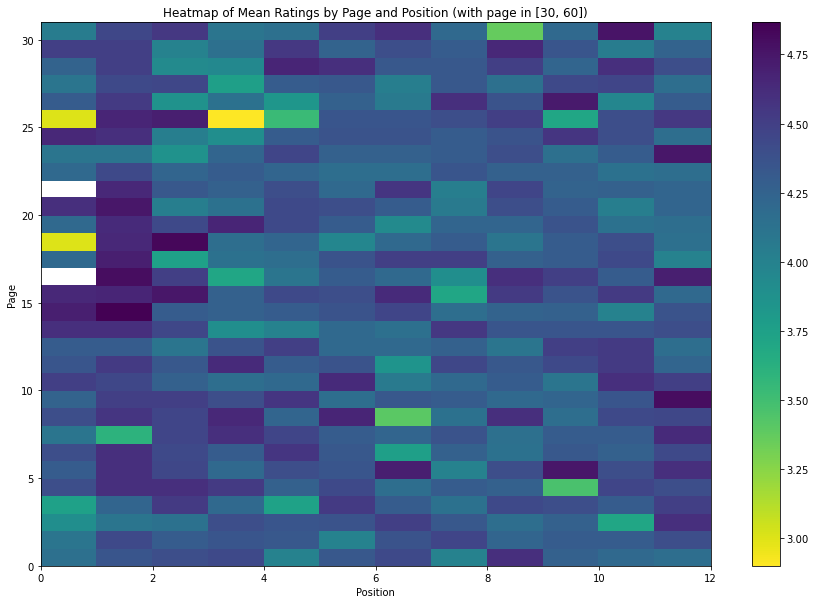

In [359]:
# Filtering the data
data = df.query('page >= 30 and page <= 60')

# Analysis of the average score according to the page and the position
mean_ratings = data.groupby(['page', 'position'])['rating'].mean().reset_index()

# Overall figure
plt.figure(figsize=(15,10))

# Creation of a heat map 
plt.pcolor(mean_ratings.pivot("page", "position", "rating"), cmap='viridis_r')
plt.colorbar()

# Titles
plt.title("Heatmap of Mean Ratings by Page and Position (with page in [30, 60])")
plt.xlabel("Position")
plt.ylabel("Page")

plt.show()
plt.close()

**Comments on the figure:** We find many more items with a rating below 3.25 stars than in the previous figure. Surprisingly, we still find highly rated products (average rating above 4.75: small dark groups) in the pages after 30. Sometimes these outliers represent items that have only been rated a few times, which does not give the product enough credit and does not contribute to sales.

In addition, the influence of human-made decisions, such as subcontracts with manufacturers or the showcasing of Amazon's own products, should not be overlooked. Like many platforms today (whether it's online retail or food delivery), these platforms host and compete with sellers. This could lead to decisions that do not optimize overall economic gains but those of a few products.

### 3.2 Between practicality and aesthetics - materials used <a class="anchor" id="section_3_2"></a>

In this section we want to know if the material used (plastic, metal, etc.) has an actual influence on the popularity of the product. We first use a naive visual approach to identify patterns linking the material used to a potential increase or decrease in score.

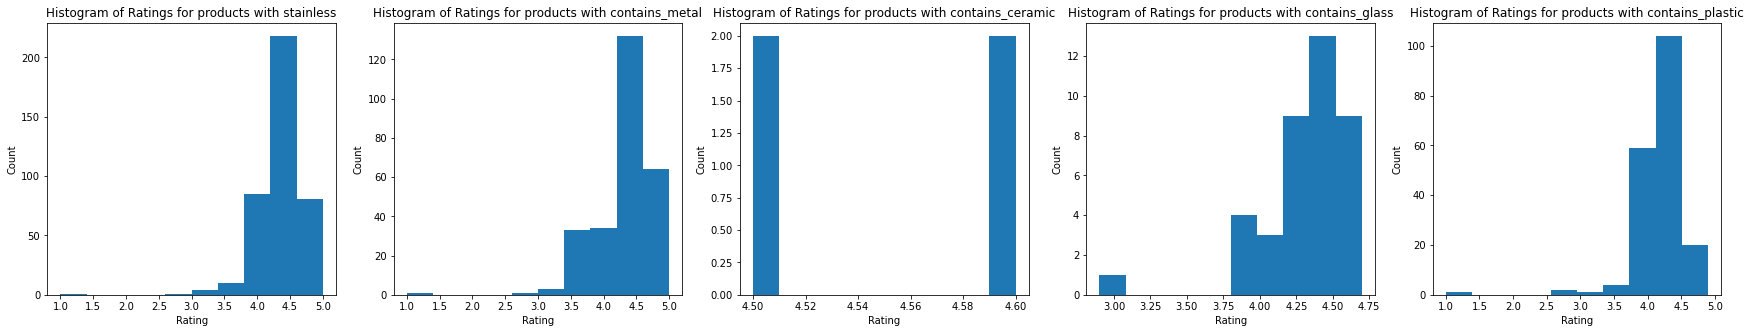

In [360]:
# List of materials used
materials = ['stainless','contains_metal', 'contains_ceramic', 'contains_glass', 'contains_plastic']
fig, axs = plt.subplots(1, len(materials), figsize=(30,5))

# Sub-plotting for each material
for i, material in enumerate(materials):
    axs[i].hist(data[data[material] == True]['rating'], bins=10)
    axs[i].set_title(f"Histogram of Ratings for products with {material}")
    axs[i].set_xlabel("Rating")
    axs[i].set_ylabel("Count")

plt.show()
plt.close()

**Commments on the figure :** We can not clearly identify a pattern related to the materials used. The results for ceramics cannot be processed because they only take into account four products among thousands.

To continue our analysis on the materials used, we will change our `rating` variable of interest to `timesRated` which could be an interesting factor of the enthusiasm behind a product. To do this, we plot for four key elements (presence of plastic, metal, stainless steel and glass) the average evaluation times of related products.

The mean timesRated for stainless is: 1698.9087557603686
The mean timesRated for contains_metal is: 1345.2209897610921
The mean timesRated for contains_ceramic is: 842.1904761904761
The mean timesRated for contains_glass is: 2937.8197278911566
The mean timesRated for contains_plastic is: 1970.7519858781995


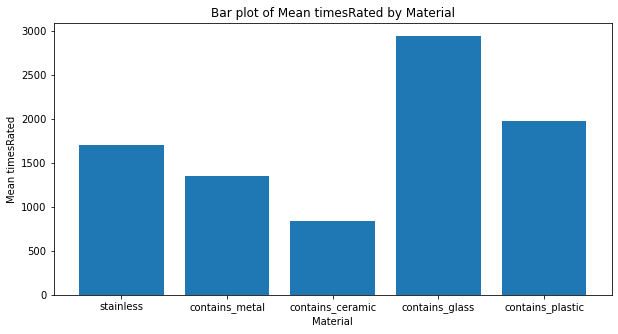

In [361]:
# Average timesRated
material_mean=[]
for material in materials:
    timesRated_mean = df[df[material] == True]['timesRated'].mean()
    print(f"The mean timesRated for {material} is: {timesRated_mean}")
    material_mean.append(timesRated_mean)

# Barplot
plt.figure(figsize=(10,5))
plt.bar(materials,material_mean)

# Titles
plt.title("Bar plot of Mean timesRated by Material")
plt.xlabel("Material")
plt.ylabel("Mean timesRated")

plt.show()
plt.close()

We note that products containing glass received more reviews on average. We do not believe that this result is really significant. But it can be interpreted as the fact that glass kettles are preferred to metal or stainless steel kettles for aesthetic reasons.

### 3.3 Impact of colors on sales <a class="anchor" id="section_3_3"></a>

We first take a look at all the scrapped and then pre-processed colours of our DataSet.

In [362]:
colors = df['color'].unique()
print("--------------- List of unique colors in the dataset : ---------------")
print(colors)

--------------- List of unique colors in the dataset : ---------------
['stainless steel' 'black' 'white' nan 'red' 'silver' 'maroon' 'gray'
 'green' 'brown' 'silver, black' 'copper' 'blue' 'black, stainless steel'
 'black, silver' 'gold' 'grey' 'stainless steel, black' 'black, gold'
 'olive, green' 'teal' 'gray, black' 'navy' 'turquoise' 'yellow'
 'maroon, red' 'white, gold' 'beige' 'b' 'black, brown' 'aqua'
 'stainless steel, silver' 'pink' 'chartreuse' 'silver, stainless steel'
 'gold, black' 'cyan' 'indigo, blue' 'black, black' 'lavender'
 'white, stainless steel' 'orange' 'b, silver' 'gold, black, silver'
 'purple']


We then put the items together in small groups according to the colours in which they are sold.

In [363]:
# we rassemble similar colors together
df["black"] = df["color"].apply(lambda x: 1 if "black" in str(x) else 0)
df["metallic"] = df["color"].apply(
    lambda x: 1
    if "silver" in str(x)
    or "gray" in str(x)
    or "grey" in str(x)
    or "stainless steel" in str(x)
    or "copper" in str(x)
    else 0
)
df["white"] = df["color"].apply(lambda x: 1 if "white" in str(x) else 0)
df["gold"] = df["color"].apply(
    lambda x: 1 if "gold" in str(x) or "yellow" in str(x) else 0
)
df["beige"] = df["color"].apply(lambda x: 1 if "beige" in str(x) else 0)
df["blue"] = df["color"].apply(
    lambda x: 1
    if "turquoise" in str(x)
    or "cyan" in str(x)
    or "blue" in str(x)
    or "indigo" in str(x)
    or "aqua" in str(x)
    else 0
)
df["green"] = df["color"].apply(
    lambda x: 1 if "green" in str(x) or "chartreuse" in str(x) else 0
)

As the rating feature did not give good indications when it comes to aesthetic features (see previous section). We will continue to use `timesRated` as a feature of interest. We now propose a visualisation of the average evaluation time of a product according to the colours in which it is sold.

The mean timesRated for black is: 1762.630855715178
The mean timesRated for metallic is: 2929.759259259259
The mean timesRated for white is: 5986.830188679245
The mean timesRated for gold is: 2612.377358490566
The mean timesRated for beige is: 649.1428571428571
The mean timesRated for blue is: 830.0
The mean timesRated for green is: 390.11170212765956


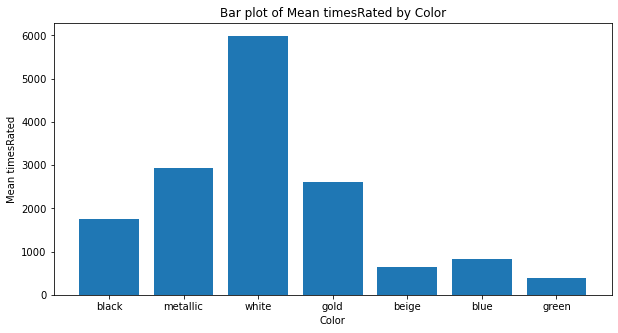

In [364]:
colors_mean = []
colors = ["black", "metallic", "white", "gold", "beige", "blue", "green"]
for color in colors:
    timesRated_mean = df[df[color] == True]["timesRated"].mean()
    print(f"The mean timesRated for {color} is: {timesRated_mean}")
    colors_mean.append(timesRated_mean)

# Barplot
plt.figure(figsize=(10, 5))
plt.bar(colors, colors_mean)

# Titles
plt.title("Bar plot of Mean timesRated by Color")
plt.xlabel("Color")
plt.ylabel("Mean timesRated")

plt.show()
plt.close()


**Comments on the figure :** White, metallic and gold colours are the most popular items. This is not surprising, as a device is often purchased in the most subdued colour possible.  

In fact we have to be careful about the conclusions we can draw. Indeed, a colour that is too generic and often easy to apply (metallic often corresponds to raw material) offers results that are difficult to interpret. Indeed, these same colours are proposed by all manufacturers. Thus gathering all the ranges of products: good note, great number of sales or items little known and badly noted. 

***

## 4. Change of perspective - ML approach <a class="anchor" id="chapter4"></a>

Our previous results do not seem to draw good conclusions. Perhaps our viewpoint is not optimal. In this section, instead of considering the feature `order` as our target variable, we will consider clusters of items. In fact, the products visible in the same web page will be considered in the same cluster. 

This new point of view allows us to implement classification algorithms. In this section, we will use a classical approach: decision trees.

**Quick intro on decision trees :**

Decision trees offer a second approach to classification. A decision tree is essentially a model that predicts the value of a target using decision rules deduced from the characteristics of the data.

Before we get to work, we can make an initial decision about the criterion we will use to compute the decision trees. When splitting a node, decision trees can use two different criterions : `entropy` and `giny`. 
$$ \text{Giny} = 1-\sum_{j=1}^n p_j^2$$
$$ \text{Entropy} = -\sum_{j=1}^n\text{log}_2(p_j)p_j$$

`entropy` takes a bit longer to calculate because it uses logarithms. In order to limit the computation time, we will therefore use the `giny` criterion.


In [365]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the JSON data into a pandas dataframe
df = pd.read_json("./AmazonProjectDataF2.json")

df.replace("None", float('nan'), inplace=True)
df.fillna(0, inplace=True)
df.dropna(inplace=True)

df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['timesRated'] = pd.to_numeric(df['timesRated'], errors='coerce')

df = pd.get_dummies(df, columns=["title"])
df = pd.get_dummies(df, columns=["Brand"])
df = pd.get_dummies(df, columns=["Country of Origin"])

# Define the features and target variables
X = df.drop(["page"], axis=1)
y = df["page"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the classifier
clf = DecisionTreeClassifier(criterion='gini')

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Test the classifier on the test data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.20266120777891505


***

## Conclusion and notes on the model <a class="anchor" id="chapter5"></a>

An algorithm for predicting featured items on Amazon only gave a prediction of 20%, this probably means that the algorithm is not able to accurately predict which items will be featured on Amazon just by looking at their features or their rating/rating time. This also confirms our analysis of the data: we found it very difficult to determine which features affect the popularity of a product. One key factor is Amazon's business strategy and goals. The company may choose to highlight certain products to drive sales or to promote certain brands or categories. For example, Amazon may feature products that are part of exclusive partnerships or advertising agreements with other companies. It may also promote items that are part of its own private label or exclusive brands.











```
⠀⠀⠀⠀⠀⠀⠀⠀⣀⣤⣤⣶⣶⣶⣶⣤⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⣠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢰⣿⣿⣿⣿⠏⠉⠀⠈⠙⣿⣿⣿⣿⣧⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠉⠉⠉⠉⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⢀⣤⣤⣶⣶⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢀⣴⣿⣿⣿⣿⠿⠛⠋⠉⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⣾⣿⣿⣿⣿⠁⠀⠀⠀⠀⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⡀⠀⠀⠀⣸⣿⣿⣿⣿⣿⡄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢻⣿⣿⣿⣿⣿⣶⣶⣿⣿⡿⣿⣿⣿⣿⣿⠆⠀⠀⠀⠀
⠠⣀⠀⠀⠀⠀⠙⠿⢿⣿⣿⣿⡿⠟⠋⠀⠙⢿⡿⠋⠀⠠⠴⠶⣶⡄
⠀⠈⠛⠶⣦⣄⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣠⣤⠶⠀⣿⠁
⠀⠀⠀⠀⠈⠙⠛⠿⢿⣿⣷⣶⣶⣶⣶⣶⣿⡿⠟⠛⠉⠁⠀⠐⠁⠀
```